### Diffraction-limited System

In [1]:
import numpy as np
from numpy import fft
import matplotlib.pyplot as plt
from PIL import Image
import ipywidgets as widgets
from IPython.display import display

In [2]:
object_intensity = np.array(Image.open("../Data/cameraman.tif"), dtype=np.float64)
object_amplitude = np.sqrt(object_intensity)
object_amplitude_ft = fft.fftshift(fft.fft2(object_amplitude))
m, n = object_amplitude.shape

In [3]:
def update(wave_length_nm):
    print(f"wave_length: {wave_length_nm:.0f} nm")
    wave_length = wave_length_nm / 1e9
    pixel_size = 0.5e-6
    k0 = 2 * np.pi / wave_length
    NA = 0.1
    cutoff_freq = NA * k0

    m, n = object_amplitude.shape
    kx = fft.fftshift(fft.fftfreq(m, d=pixel_size)) * 2 * np.pi
    ky = fft.fftshift(fft.fftfreq(n, d=pixel_size)) * 2 * np.pi
    kx, ky = np.meshgrid(kx, ky)

    ctf = (kx**2 + ky**2) < cutoff_freq**2
    ipsf = np.abs(fft.ifft2(fft.ifftshift(ctf))) ** 2
    otf = np.abs(fft.fftshift(fft.fft2(fft.ifftshift(ipsf))))
    otf /= np.max(otf)

    output_ft_coherent = ctf * object_amplitude_ft
    output_ft_incoherent = otf * object_amplitude_ft

    output_amplitude_coherent = fft.ifft2(fft.ifftshift(output_ft_coherent))
    output_amplitude_incoherent = fft.ifft2(fft.ifftshift(output_ft_incoherent))

    _, axs = plt.subplots(2, 2, figsize=(10, 10))

    axs[0][0].imshow(np.log(np.abs(output_ft_coherent) + 1), cmap="gray")
    axs[0][0].set_title("Filtered spectrum in the spatial frequency domain")
    axs[0][0].axis("off")

    axs[0][1].imshow(np.abs(output_amplitude_coherent), cmap="gray")
    axs[0][1].set_title("Coherent transfer function")
    axs[0][1].axis("off")

    axs[1][0].imshow(np.log(np.abs(output_ft_incoherent) + 1), cmap="gray")
    axs[1][0].axis("off")

    axs[1][1].imshow(np.abs(output_amplitude_incoherent), cmap="gray")
    axs[1][1].set_title("Incoherent transfer function")
    axs[1][1].axis("off")

    plt.tight_layout()
    plt.show()


slider = widgets.FloatSlider(
    value=500, min=100, max=1500, step=50, description="wave_length"
)

plot = widgets.interactive(update, wave_length_nm=slider)

display(plot)

interactive(children=(FloatSlider(value=500.0, description='wave_length', max=1500.0, min=100.0, step=50.0), O…

### 1.3

![](../Resources/Zernike_circle.png)

In [4]:
from poppy.zernike import zernike

wave_length = 0.5e-6
pixel_size = 0.5e-6
k0 = 2 * np.pi / wave_length
NA = 0.1
cutoff_freq = NA * k0

m, n = object_amplitude.shape
kx = fft.fftshift(fft.fftfreq(m, d=pixel_size)) * 2 * np.pi
ky = fft.fftshift(fft.fftfreq(n, d=pixel_size)) * 2 * np.pi
kx, ky = np.meshgrid(kx, ky)

rho = np.sqrt(kx**2 + ky**2) / cutoff_freq
theta = np.arctan2(ky, kx)

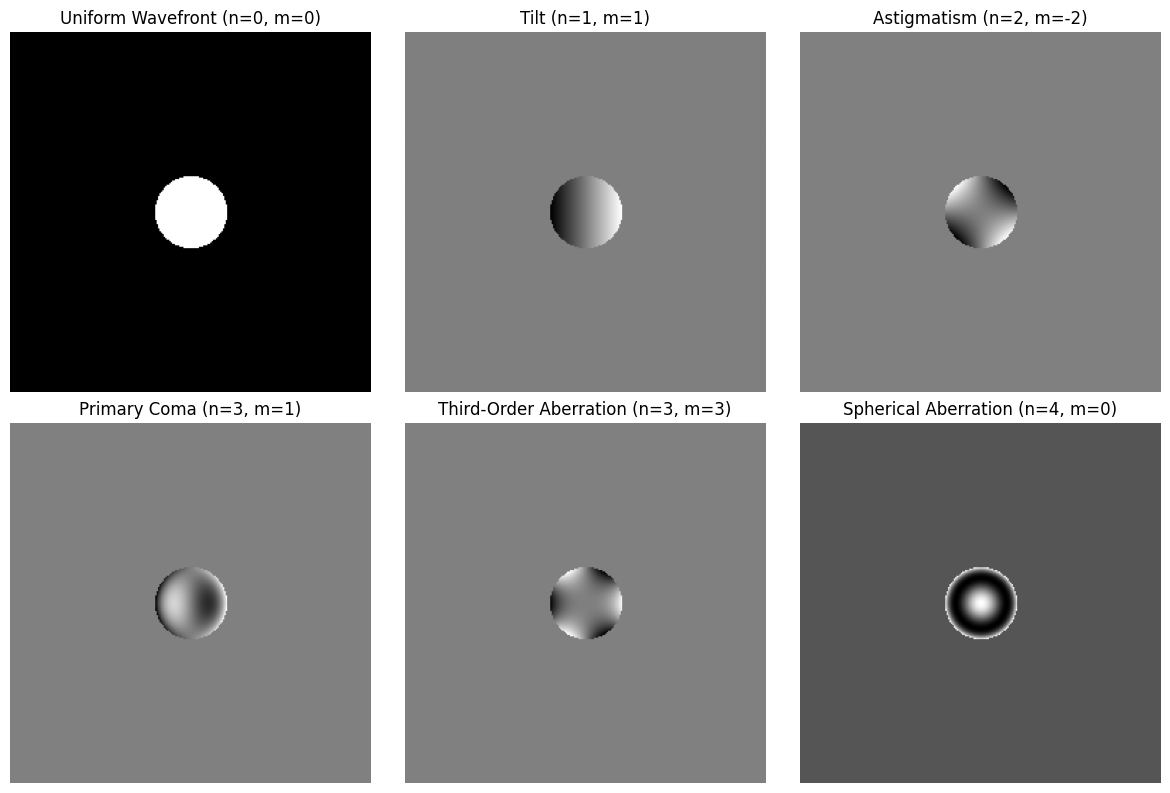

In [5]:
zernike_modes = {
    "Uniform Wavefront": (0, 0),
    "Tilt": (1, 1),  # 1, ±1
    "Astigmatism": (2, -2),  # 2, ±2
    "Primary Coma": (3, 1),
    "Third-Order Aberration": (3, 3),  # 3, ±3
    "Spherical Aberration": (4, 0),
}

_, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.ravel()

for i, (mode_name, (n, m)) in enumerate(zernike_modes.items()):
    Z = zernike(n, m, rho=rho, theta=theta, outside=0)
    axs[i].imshow(Z, cmap="gray", extent=(-1, 1, -1, 1))
    axs[i].set_title(f"{mode_name} (n={n}, m={m})")
    axs[i].axis("off")

plt.tight_layout()
plt.show()

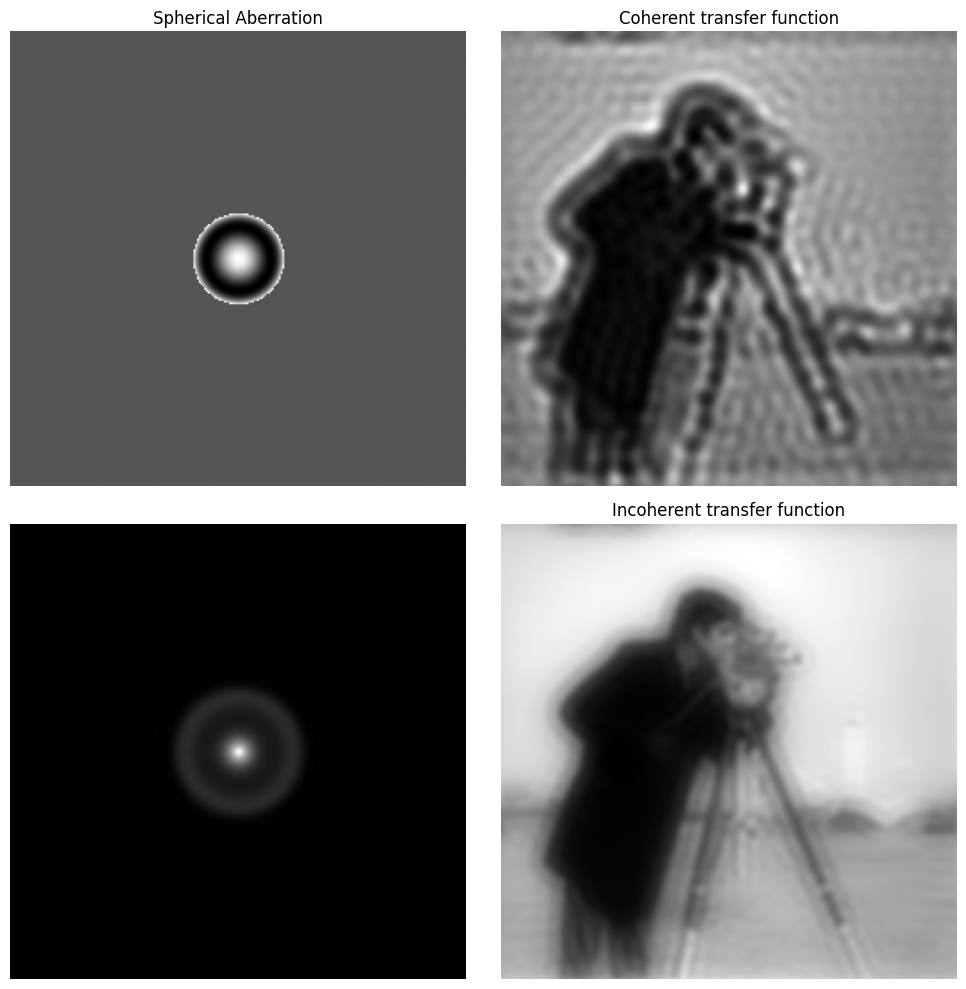

In [6]:
wave_length = 0.5e-6
pixel_size = 0.5e-6
k0 = 2 * np.pi / wave_length
NA = 0.1
cutoff_freq = NA * k0

m, n = object_amplitude.shape
kx = fft.fftshift(fft.fftfreq(m, d=pixel_size)) * 2 * np.pi
ky = fft.fftshift(fft.fftfreq(n, d=pixel_size)) * 2 * np.pi
kx, ky = np.meshgrid(kx, ky)

ctf = (kx**2 + ky**2) < cutoff_freq**2

rho = np.sqrt(kx**2 + ky**2) / cutoff_freq
theta = np.arctan2(ky, kx)

W = zernike(4, 0, rho=rho, theta=theta, outside=0)

ctf = np.exp(1j * W) * ctf

ipsf = np.abs(fft.ifft2(fft.ifftshift(ctf))) ** 2
otf = np.abs(fft.fftshift(fft.fft2(fft.ifftshift(ipsf))))
otf /= np.max(otf)

output_ft_coherent = ctf * object_amplitude_ft
output_ft_incoherent = otf * object_amplitude_ft

output_amplitude_coherent = fft.ifft2(fft.ifftshift(output_ft_coherent))
output_amplitude_incoherent = fft.ifft2(fft.ifftshift(output_ft_incoherent))

_, axs = plt.subplots(2, 2, figsize=(10, 10))

axs = axs.ravel()

axs[0].imshow(np.angle(ctf), cmap="gray")
axs[0].set_title("Spherical Aberration")
axs[0].axis("off")

axs[1].imshow(np.abs(output_amplitude_coherent**2), cmap="gray")
axs[1].set_title("Coherent transfer function")
axs[1].axis("off")

axs[2].imshow(otf, cmap="gray")
axs[2].axis("off")

axs[3].imshow(np.abs(output_amplitude_incoherent**2), cmap="gray")
axs[3].set_title("Incoherent transfer function")
axs[3].axis("off")

plt.tight_layout()
plt.show()

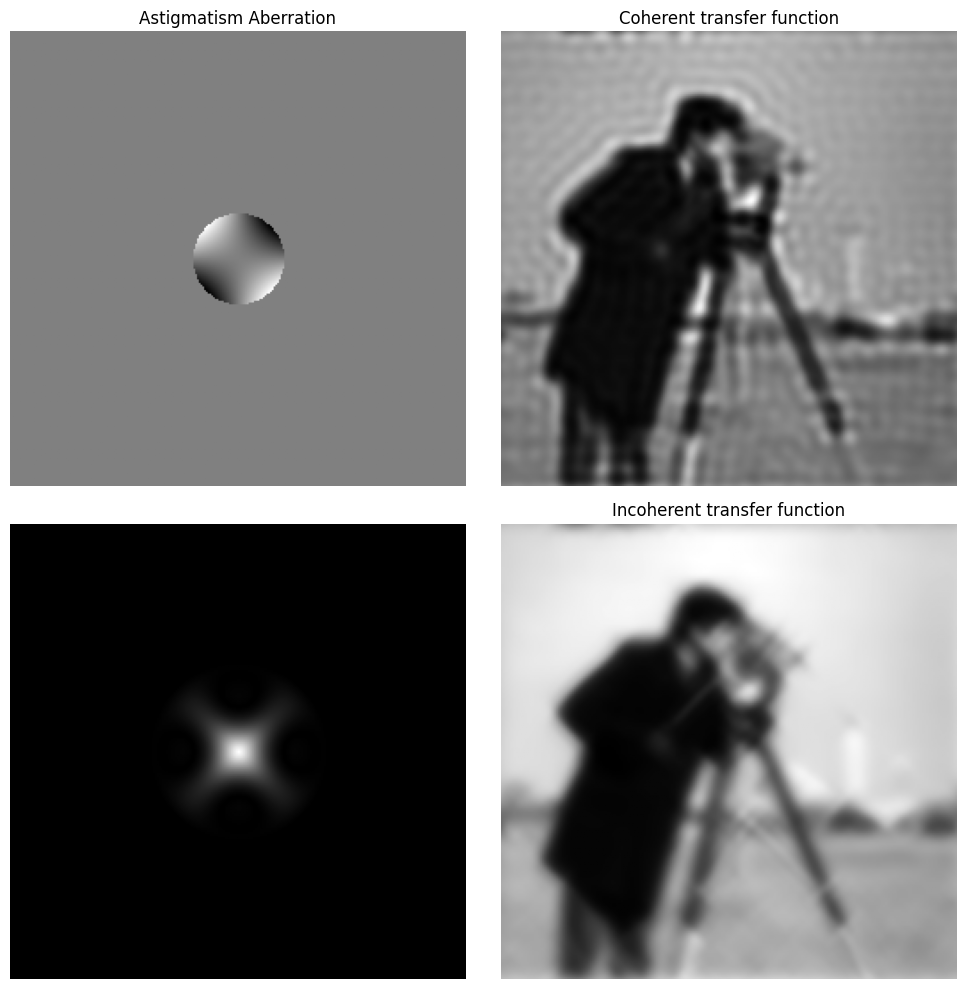

In [7]:
wave_length = 0.5e-6
pixel_size = 0.5e-6
k0 = 2 * np.pi / wave_length
NA = 0.1
cutoff_freq = NA * k0

m, n = object_amplitude.shape
kx = fft.fftshift(fft.fftfreq(m, d=pixel_size)) * 2 * np.pi
ky = fft.fftshift(fft.fftfreq(n, d=pixel_size)) * 2 * np.pi
kx, ky = np.meshgrid(kx, ky)

ctf = (kx**2 + ky**2) < cutoff_freq**2

rho = np.sqrt(kx**2 + ky**2) / cutoff_freq
theta = np.arctan2(ky, kx)

W = zernike(2, -2, rho=rho, theta=theta, outside=0)

ctf = np.exp(1j * W) * ctf

ipsf = np.abs(fft.ifft2(fft.ifftshift(ctf))) ** 2
otf = np.abs(fft.fftshift(fft.fft2(fft.ifftshift(ipsf))))
otf /= np.max(otf)

output_ft_coherent = ctf * object_amplitude_ft
output_ft_incoherent = otf * object_amplitude_ft

output_amplitude_coherent = fft.ifft2(fft.ifftshift(output_ft_coherent))
output_amplitude_incoherent = fft.ifft2(fft.ifftshift(output_ft_incoherent))

_, axs = plt.subplots(2, 2, figsize=(10, 10))

axs = axs.ravel()

axs[0].imshow(np.angle(ctf), cmap="gray")
axs[0].set_title("Astigmatism Aberration")
axs[0].axis("off")

axs[1].imshow(np.abs(output_amplitude_coherent**2), cmap="gray")
axs[1].set_title("Coherent transfer function")
axs[1].axis("off")

axs[2].imshow(otf, cmap="gray")
axs[2].axis("off")

axs[3].imshow(np.abs(output_amplitude_incoherent**2), cmap="gray")
axs[3].set_title("Incoherent transfer function")
axs[3].axis("off")

plt.tight_layout()
plt.show()

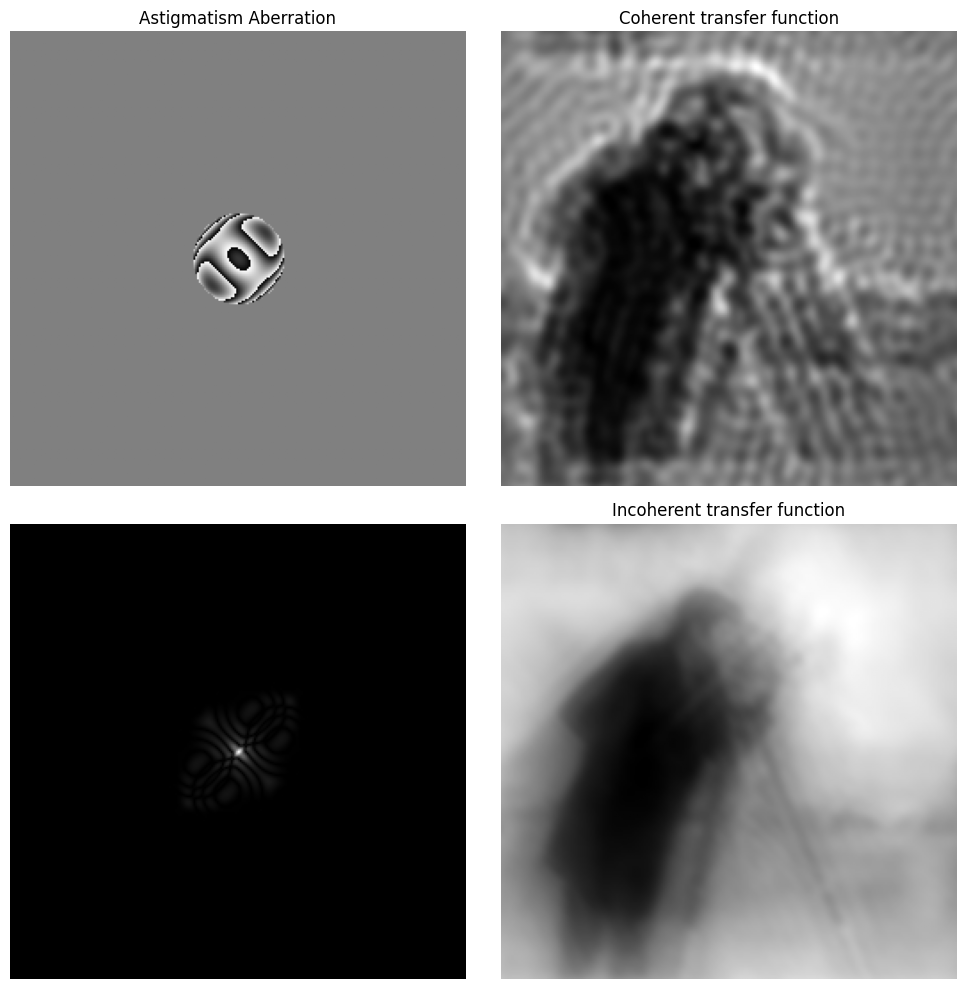

In [8]:
wave_length = 0.5e-6
pixel_size = 0.5e-6
k0 = 2 * np.pi / wave_length
NA = 0.1
cutoff_freq = NA * k0

m, n = object_amplitude.shape
kx = fft.fftshift(fft.fftfreq(m, d=pixel_size)) * 2 * np.pi
ky = fft.fftshift(fft.fftfreq(n, d=pixel_size)) * 2 * np.pi
kx, ky = np.meshgrid(kx, ky)

ctf = (kx**2 + ky**2) < cutoff_freq**2

rho = np.sqrt(kx**2 + ky**2) / cutoff_freq
theta = np.arctan2(ky, kx)

W = 2 * zernike(4, 0, rho=rho, theta=theta, outside=0) + 4 * zernike(
    2, -2, rho=rho, theta=theta, outside=0
)

ctf = np.exp(1j * W) * ctf

ipsf = np.abs(fft.ifft2(fft.ifftshift(ctf))) ** 2
otf = np.abs(fft.fftshift(fft.fft2(fft.ifftshift(ipsf))))
otf /= np.max(otf)

output_ft_coherent = ctf * object_amplitude_ft
output_ft_incoherent = otf * object_amplitude_ft

output_amplitude_coherent = fft.ifft2(fft.ifftshift(output_ft_coherent))
output_amplitude_incoherent = fft.ifft2(fft.ifftshift(output_ft_incoherent))

_, axs = plt.subplots(2, 2, figsize=(10, 10))

axs = axs.ravel()

axs[0].imshow(np.angle(ctf), cmap="gray")
axs[0].set_title("Astigmatism Aberration")
axs[0].axis("off")

axs[1].imshow(np.abs(output_amplitude_coherent**2), cmap="gray")
axs[1].set_title("Coherent transfer function")
axs[1].axis("off")

axs[2].imshow(otf, cmap="gray")
axs[2].axis("off")

axs[3].imshow(np.abs(output_amplitude_incoherent**2), cmap="gray")
axs[3].set_title("Incoherent transfer function")
axs[3].axis("off")

plt.tight_layout()
plt.show()

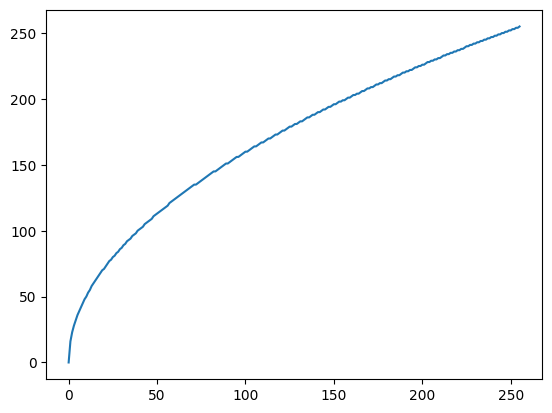

In [9]:
amp = [np.sqrt(i) for i in range(256)]
amp_max = np.max(amp)
amp_norm = amp / amp_max * 255
amp_norm_int = np.round(amp_norm).astype(int)
plt.plot(amp_norm_int);